In [15]:
import os
import pandas as pd
from tensorboard.backend.event_processing import event_accumulator

# Specify the path to your logs
log_dir = "/Users/agreic/Desktop/testing_dir/logs/aggregated_logs"

# Initialize an empty list to store data
data = []

# Loop through all subdirectories and files to find TensorBoard logs
for root, dirs, files in os.walk(log_dir):
    for file in files:
        if "events" in file:
            event_path = os.path.join(root, file)
            ea = event_accumulator.EventAccumulator(event_path)
            ea.Reload()

            # Get the name of the parent directory of `root`
            parent_dir = os.path.basename(os.path.dirname(root)).replace("LR_Model_", "").replace("_logs", "")

            # Extract scalars and add them to the data list
            for tag in ea.Tags()["scalars"]:
                for scalar_event in ea.Scalars(tag):
                    data.append({
                        "tag": tag,
                        "step": scalar_event.step,
                        "value": scalar_event.value,
                        "file": parent_dir  # Use the parent directory name
                    })

# Convert to a DataFrame
df = pd.DataFrame(data)
print(df.head())

# Create a color column
# Starting palette with distinct colors for single markers
palette = {
    "PU1": "#1f77b4",   # muted blue
    "SCA1": "#ff7f0e",  # muted orange
    "GATA1": "#2ca02c", # muted green
    "CD41": "#d62728",   # muted red
    "None": "white"      # white for no markers
}

palette = {
    "PU1": "cyan",   # muted blue
    "SCA1": "green",  # muted orange
    "GATA1": "blue", # muted green
    "CD41": "pink",   # muted red
    "None": "white"      # white for no markers
}

# Initialize the color column
df['color'] = 'white'  # Default color for rows with no known markers

# Assign colors based on marker presence in the 'file' column
for marker, color in palette.items():
    df.loc[df['file'].str.contains(marker, case=False, na=False), 'color'] = color

# Select distinct shapes for up to 9 instances
distinct_shapes = ["o", "s", "p", "*", "D", "d", "H", "X", "x"]

# Initialize shape column and assign based on marker instances
df['shape'] = None
df['instance'] = df['file'].str.extract(r'_(\d+)$').astype(float)  # Extract instance number at end of 'file'
df['marker'] = df['file'].str.extract(r'^(.*?)_')[0].str.upper()  # Extract marker name at beginning of 'file'

# Map instances to shapes
instance_shape_map = {i + 1: shape for i, shape in enumerate(distinct_shapes)}
df['shape'] = df['instance'].map(instance_shape_map).fillna("o")  # Default to "o" if instance is missing

# Sort df by instance
df = df.sort_values("instance")

# Display the DataFrame to verify color and shape assignments
print(df.head())

                  tag  step     value    file
0           hp_metric     0 -1.000000  CD41_3
1  training_loss_step     9  0.567407  CD41_3
2  training_loss_step    19  0.343374  CD41_3
3  training_loss_step    29  0.327000  CD41_3
4  training_loss_step    39  0.314466  CD41_3
                        tag   step      value     file  color shape  instance  \
296019  training_loss_epoch  62299   0.285459  GATA1_1   blue     o       1.0   
221204                epoch  22269  35.000000   Sca1_1  green     o       1.0   
221203                epoch  22259  35.000000   Sca1_1  green     o       1.0   
221202                epoch  22249  35.000000   Sca1_1  green     o       1.0   
221201                epoch  22239  35.000000   Sca1_1  green     o       1.0   

       marker  
296019  GATA1  
221204   SCA1  
221203   SCA1  
221202   SCA1  
221201   SCA1  


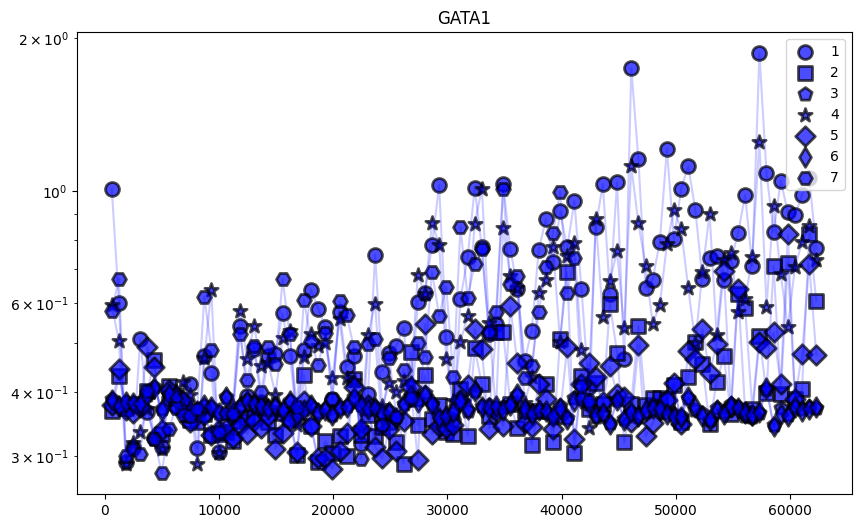

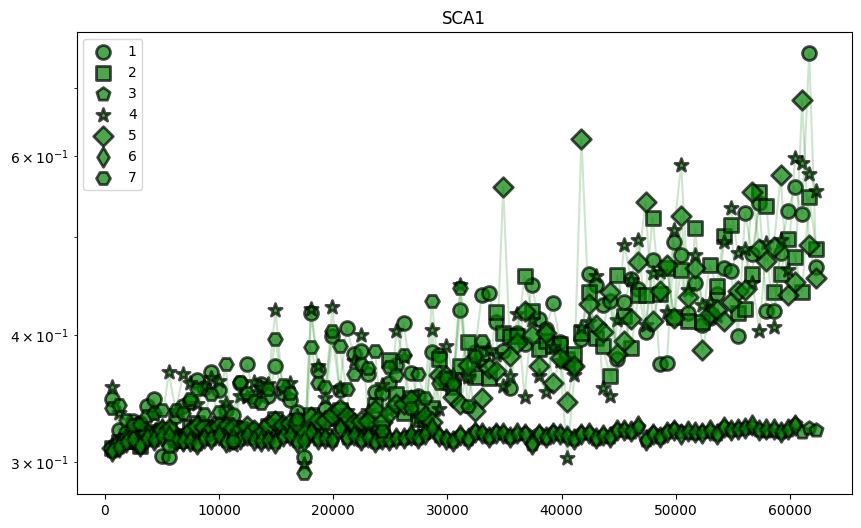

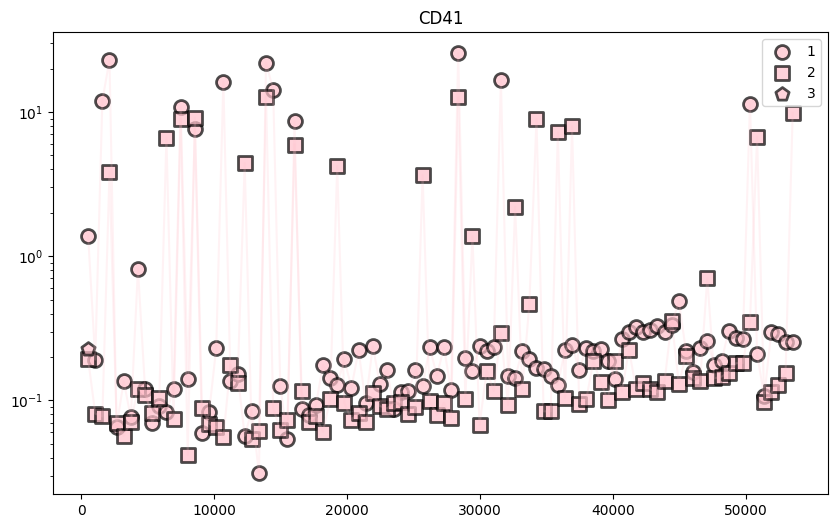

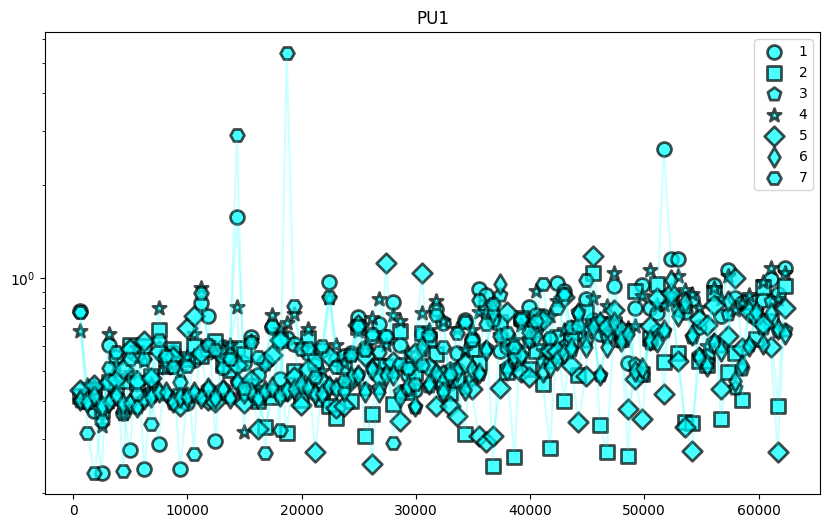

In [16]:
# For each marker, generate its own line + scatter plot
import seaborn as sns
import matplotlib.pyplot as plt

for marker in df['marker'].unique():
    # Filter the DataFrame to only include the current marker
    marker_df = df[df['marker'] == marker]
    # Filter to include metric of interest
    marker_df = marker_df[marker_df['tag'] == 'val_loss']

    # Initialize the plot
    plt.figure(figsize=(10, 6))
    plt.title(f"{marker}")

    # Create the line plot
    for instance in marker_df['instance'].unique():
        instance_df = marker_df[marker_df['instance'] == instance]
        instance_df = instance_df.sort_values("step")
        plt.plot(instance_df['step'], instance_df['value'], color=palette[marker], linestyle='-', alpha=.2)
        plt.scatter(instance_df['step'], instance_df['value'], color=palette[marker], marker=instance_shape_map[instance], s=100, label=f'{int(instance)}', alpha=.7, edgecolor='black', linewidth=2)
    plt.yscale('log')
    plt.legend(title='')
    plt.show()

In [3]:
df

,tag,step,value,file,color,shape,instance,marker
296019,training_loss_epoch,62299,0.285459,GATA1_1,#2ca02c,o,1.0,GATA1
221204,epoch,22269,35.000000,Sca1_1,#ff7f0e,o,1.0,SCA1
221203,epoch,22259,35.000000,Sca1_1,#ff7f0e,o,1.0,SCA1
221202,epoch,22249,35.000000,Sca1_1,#ff7f0e,o,1.0,SCA1
221201,epoch,22239,35.000000,Sca1_1,#ff7f0e,o,1.0,SCA1
...,...,...,...,...,...,...,...,...
274180,epoch,43759,70.000000,PU1_7,#1f77b4,H,7.0,PU1
274179,epoch,43749,70.000000,PU1_7,#1f77b4,H,7.0,PU1
274178,epoch,43739,70.000000,PU1_7,#1f77b4,H,7.0,PU1
274191,epoch,43869,70.000000,PU1_7,#1f77b4,H,7.0,PU1


100 100


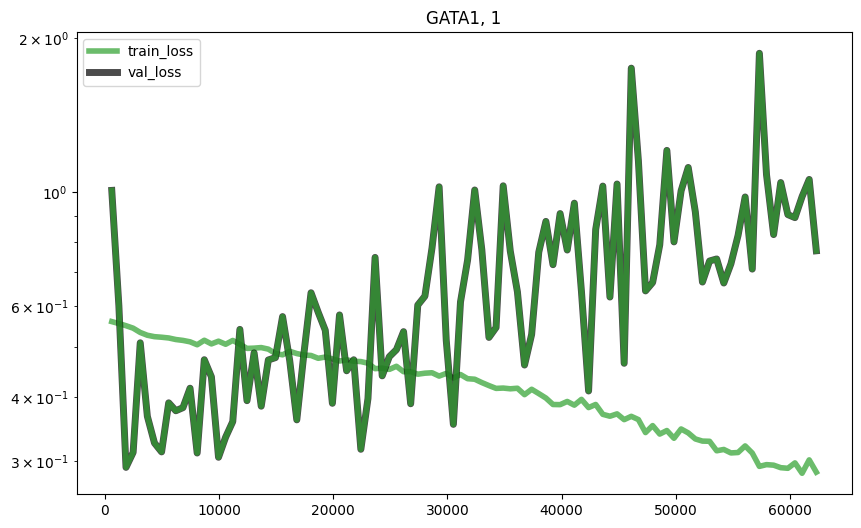

100 100


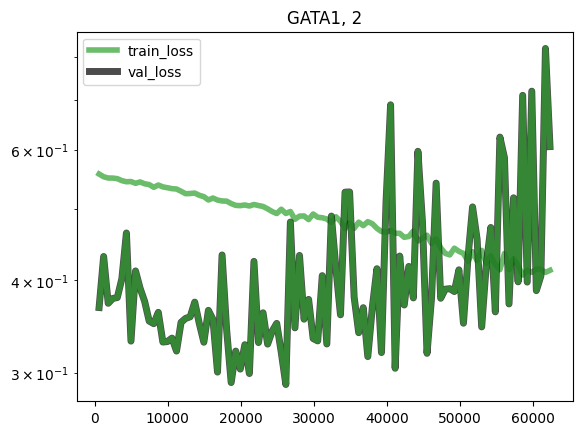

100 100


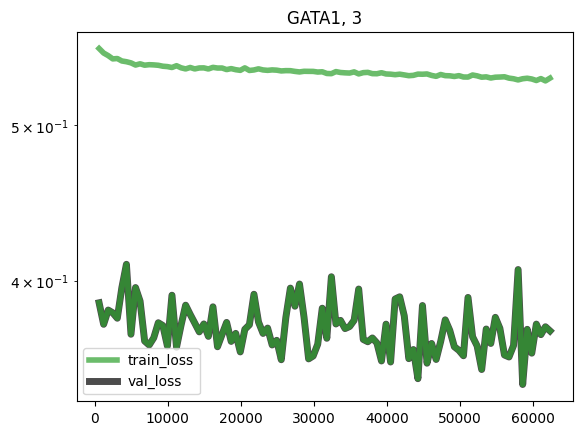

100 100


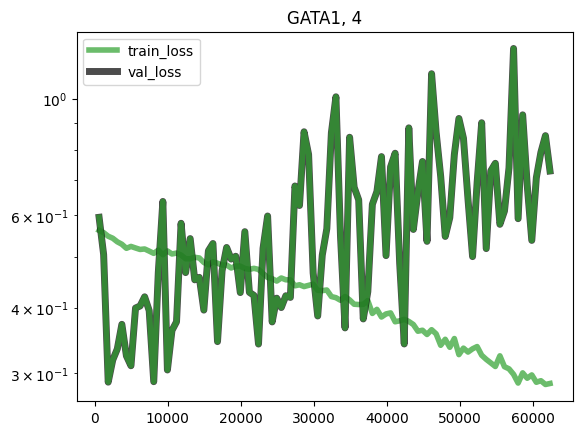

100 100


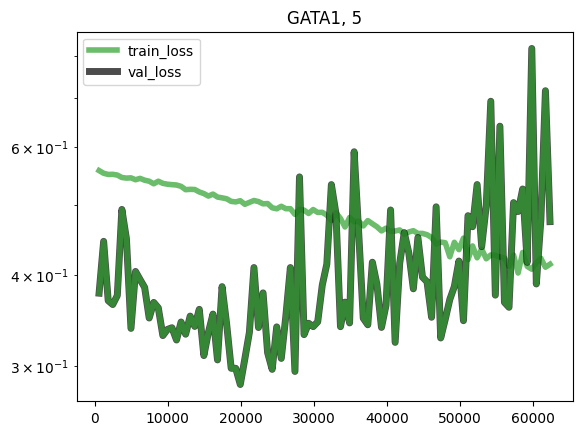

100 100


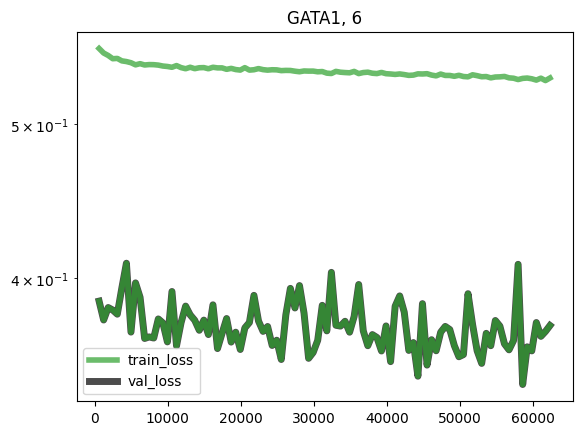

68 68


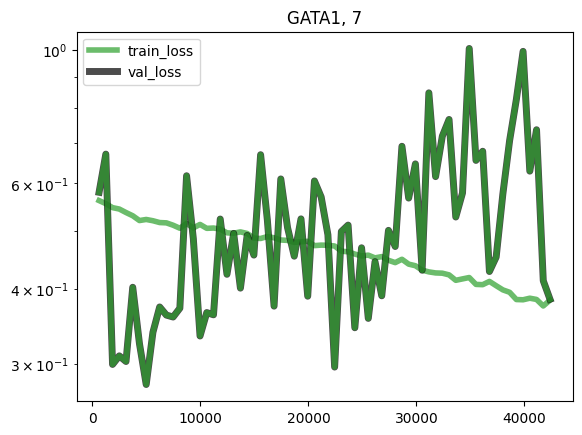

100 100


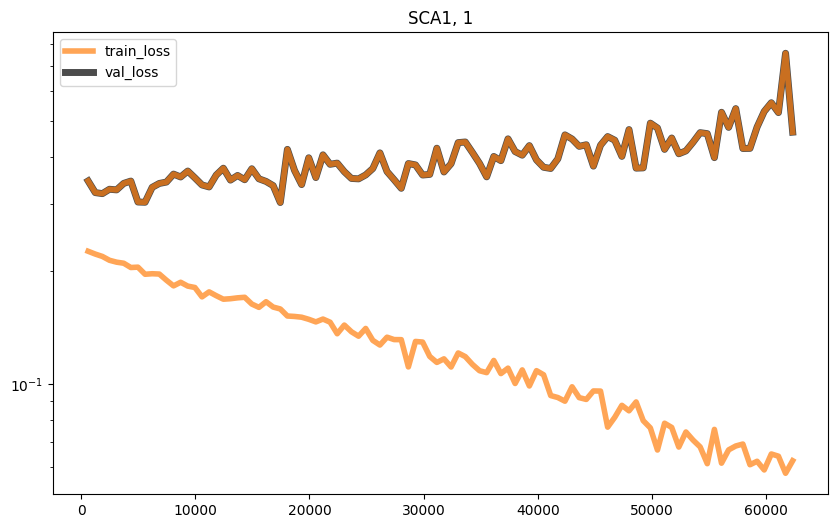

100 100


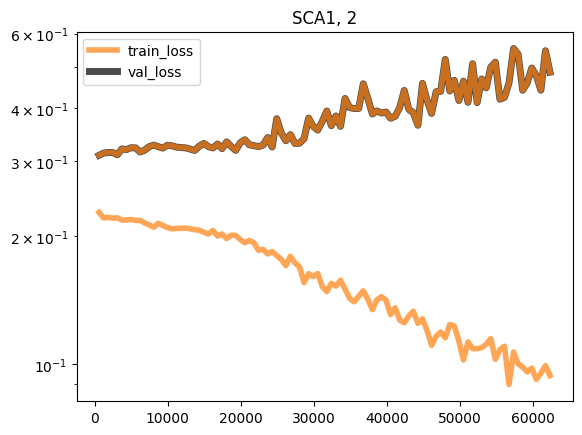

100 100


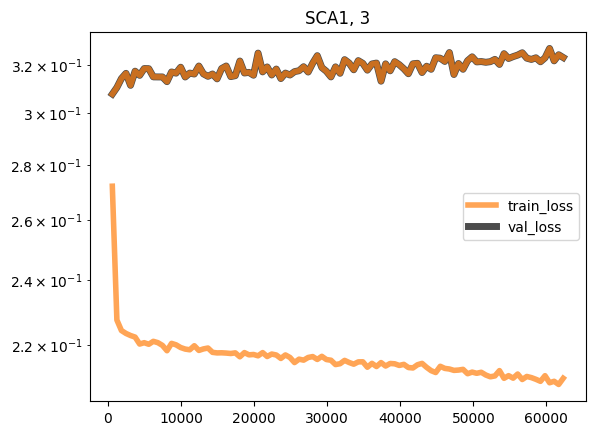

100 100


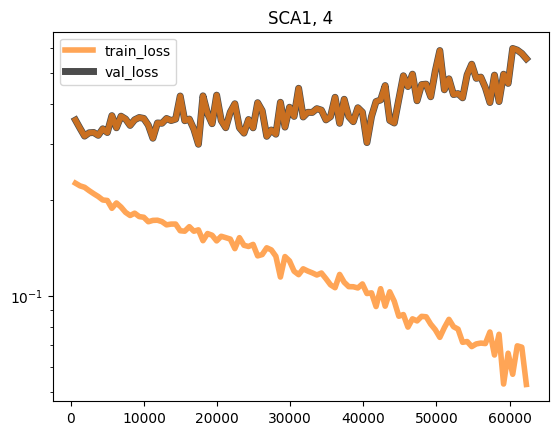

100 100


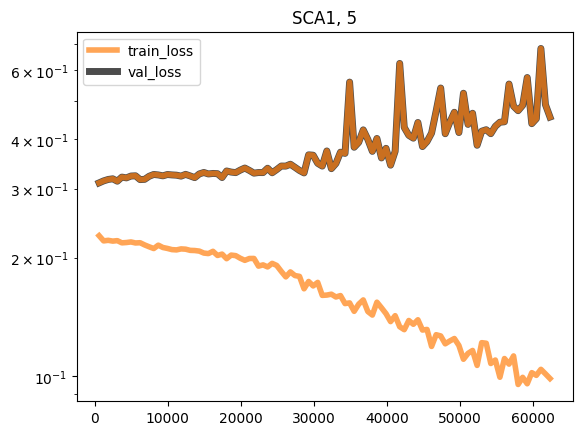

97 97


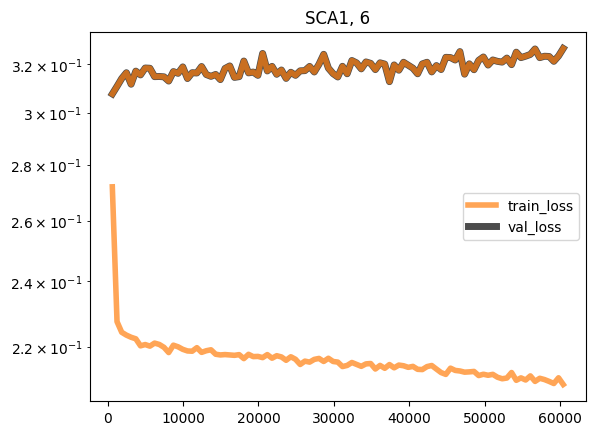

53 53


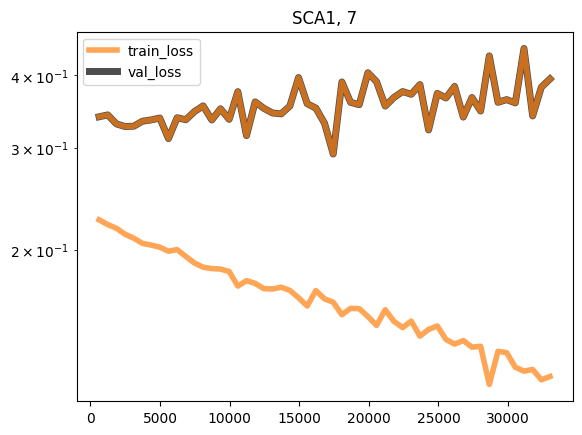

100 100


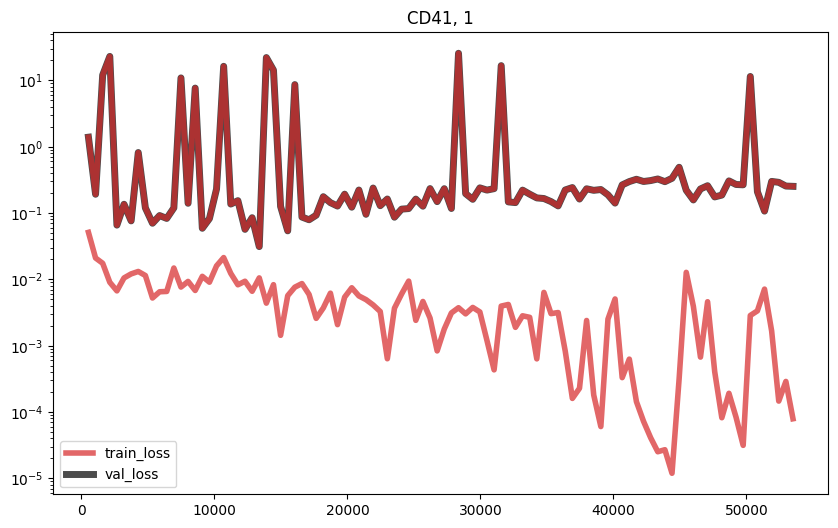

100 100


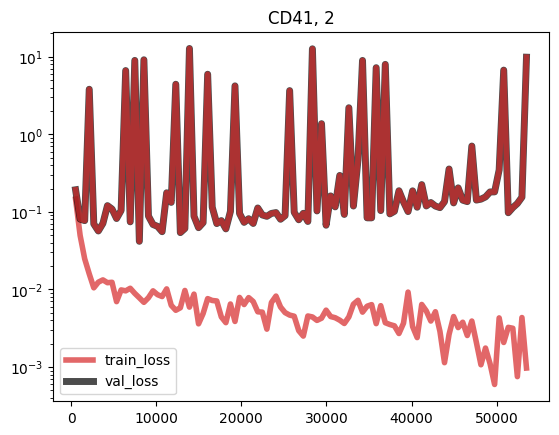

1 1


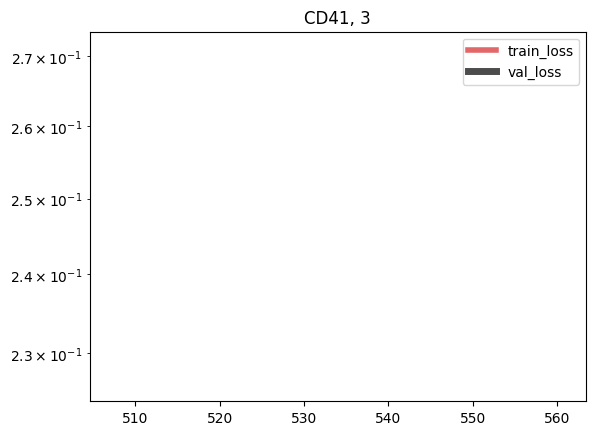

100 100


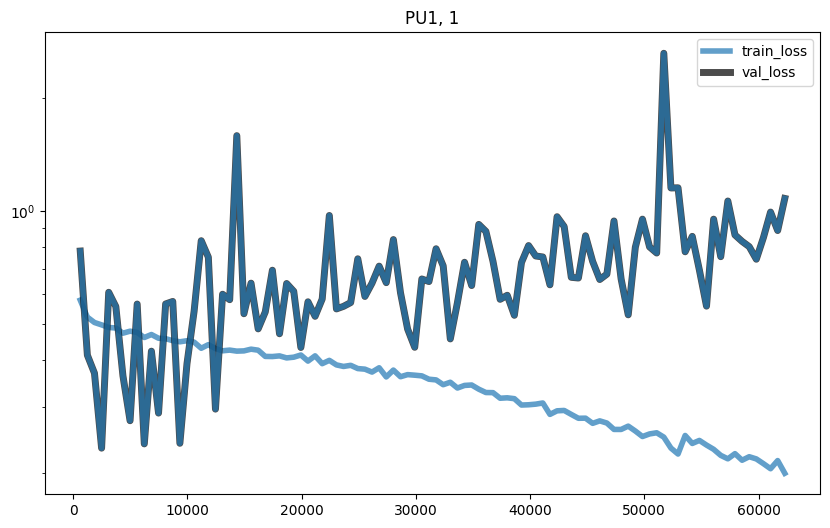

100 100


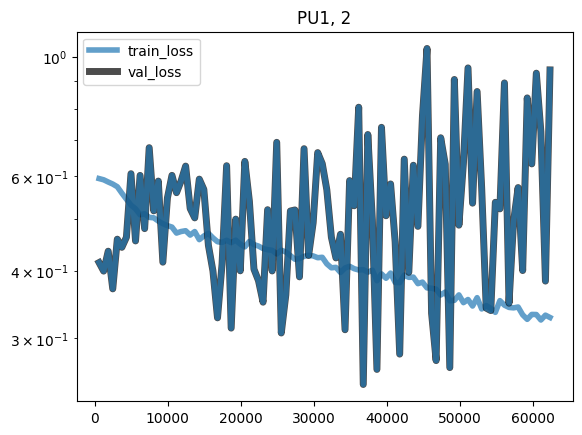

100 100


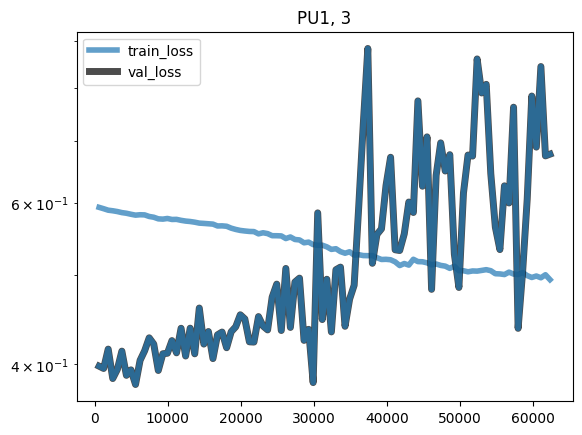

100 100


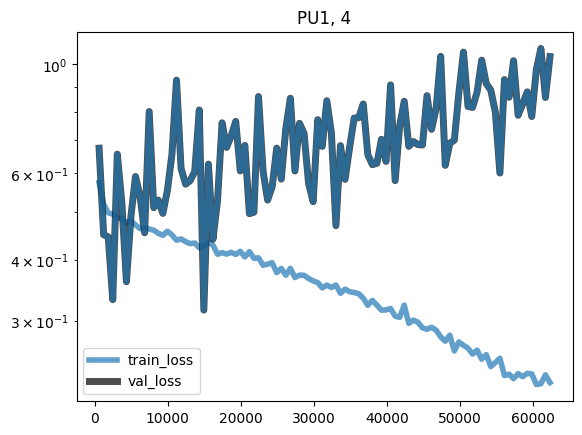

100 100


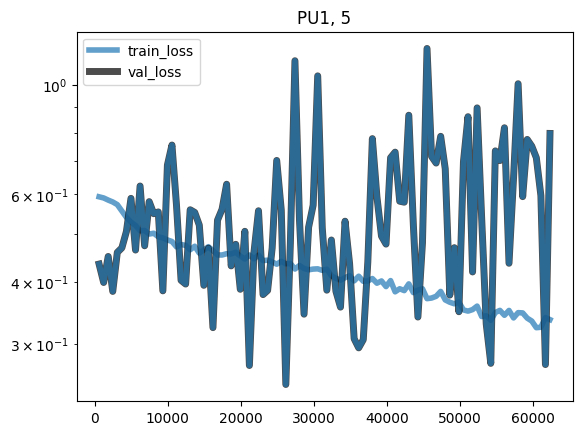

100 100


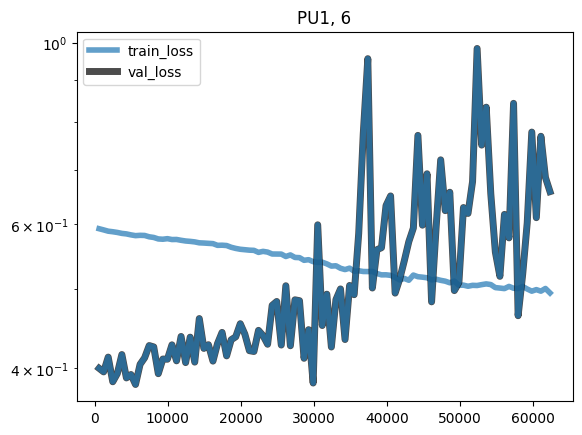

72 72


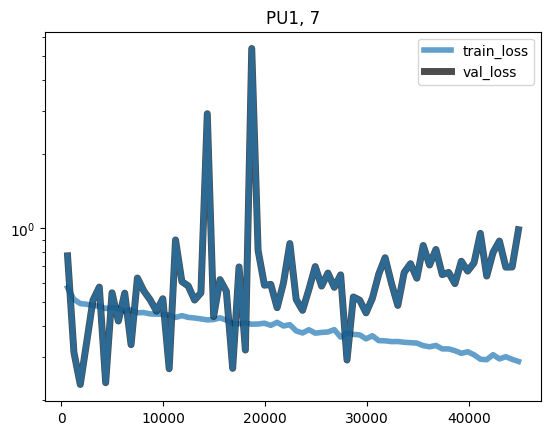

In [4]:
# maybe show how the val_loss behaves when compared to train_loss

# For each marker, generate its own line + scatter plot
import seaborn as sns
import matplotlib.pyplot as plt

for marker in df['marker'].unique():
    # Filter the DataFrame to only include the current marker
    marker_df = df[df['marker'] == marker]
    # Filter to include metric of interest
    marker_df_val_loss = marker_df[marker_df['tag'] == 'val_loss']
    marker_df_training_loss_epoch = marker_df[marker_df['tag'] == 'training_loss_epoch']

    # Initialize the plot
    plt.figure(figsize=(10, 6))
    plt.title(f"{marker}")

    # Create the line plot
    for instance in marker_df['instance'].unique():
        instance_df_train = marker_df_training_loss_epoch[marker_df_training_loss_epoch['instance'] == instance]
        instance_df_train = instance_df_train.sort_values("step")
        instance_df_val = marker_df_val_loss[marker_df_val_loss['instance'] == instance]
        instance_df_val = instance_df_val.sort_values("step")

        # Print length of train and val
        print(len(instance_df_train), len(instance_df_val))

        plt.plot(instance_df_train['step'], instance_df_train['value'], color=palette[marker], linestyle='-', alpha=.7, linewidth=4)
        plt.plot(instance_df_val['step'], instance_df_val['value'], color='black', linestyle='-', alpha=.7, linewidth=5)
        plt.plot(instance_df_val['step'], instance_df_val['value'], color=palette[marker], linestyle='-', alpha=.7, linewidth=4)
        
        plt.yscale('log')
        plt.title(f"{marker}, {int(instance)}")
        plt.legend(title='', labels=['train_loss', 'val_loss'])
        plt.show()


In [5]:
# CD41_3 check
check = df[df['file'] == 'CD41_3']
check

,tag,step,value,file,color,shape,instance,marker
0,hp_metric,0,-1.000000,CD41_3,#d62728,p,3.0,CD41
136,training_loss_epoch,534,0.271158,CD41_3,#d62728,p,3.0,CD41
44,training_loss_step,439,0.123596,CD41_3,#d62728,p,3.0,CD41
45,training_loss_step,449,0.544832,CD41_3,#d62728,p,3.0,CD41
46,training_loss_step,459,0.113525,CD41_3,#d62728,p,3.0,CD41
...,...,...,...,...,...,...,...,...
3,training_loss_step,29,0.327000,CD41_3,#d62728,p,3.0,CD41
8,training_loss_step,79,0.268378,CD41_3,#d62728,p,3.0,CD41
5,training_loss_step,49,0.552565,CD41_3,#d62728,p,3.0,CD41
6,training_loss_step,59,0.290579,CD41_3,#d62728,p,3.0,CD41


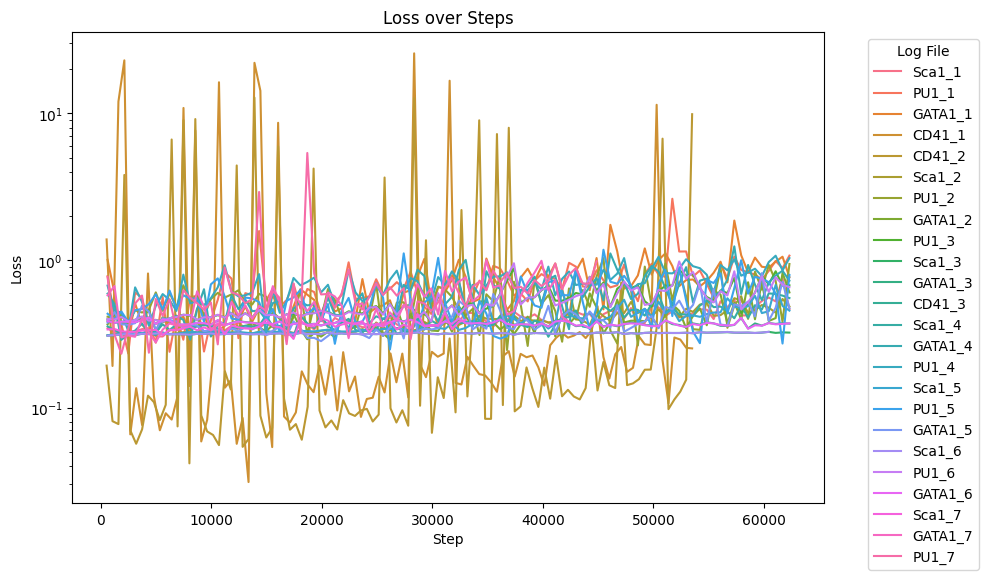

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter for a specific tag if needed, e.g., "loss"
df_loss = df[df["tag"] == "val_loss"]

# Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_loss, x="step", y="value", hue="file")
# sns.scatterplot(data=df_loss, x = "step", y = "value", markers = "shape", palette = "color")
plt.title("Loss over Steps")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.yscale("log")
plt.legend(title="Log File", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [7]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Print unique tags to check for correctness
# # print(df['tag'].unique())

# tags_of_interest = ['val_loss', 'val_accuracy', 'val_f1']#, 'training_loss_epoch']

# # Filter the DataFrame by the tags of interest
# df_training_loss_epoch = df[df["tag"] == "training_loss_epoch"]
# df_training_loss_step = df[df["tag"] == "training_loss_step"]

# # Display value counts of 'file' for each tag
# # print("Epoch-wise counts per file:\n", df_training_loss_epoch['file'].value_counts())
# # print("Step-wise counts per file:\n", df_training_loss_step['file'].value_counts())

# # Calculate the average number of steps per epoch for each log file
# steps_per_epoch = df_training_loss_step.groupby("file")["step"].max() / df_training_loss_epoch.groupby("file").size()

# # Round the steps per epoch
# steps_per_epoch_rounded = steps_per_epoch.round().astype(int)
# # Make it a multiple of 10
# steps_per_epoch_rounded = steps_per_epoch_rounded.apply(lambda x: x + (10 - x % 10) if x % 10 != 0 else x)
# print("Average steps per epoch:\n", steps_per_epoch_rounded)
# # print(df)

# df_ = df[df['tag'].isin(tags_of_interest)]
# print(df_['step'].unique())
# # Looks like only steps where epoch is ended are recorded.

# # add 'epoch' columns, which is the epoch number, which is the index of the sorted steps list for that file
# df_['epoch'] = df_.groupby('file')['step'].rank(method='dense').astype(int)
# print(df_['epoch'].unique())

In [8]:
for tag in tags_of_interest:
    df_tag = df[df["tag"] == tag]

    # Plot using Seaborn
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_tag, x="step", y="value", hue="file")
    plt.title(f"{tag} over steps")
    plt.xlabel("step")
    plt.ylabel(tag)
    # plt.yscale("log")
    plt.legend(title="Log File", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

NameError: name 'tags_of_interest' is not defined

In [137]:
# def smooth_series(values, window_size=5):
#     return values.rolling(window=window_size, min_periods=1, center=True).mean()

# # Apply smoothing to your DataFrame
# df_loss['smoothed_value'] = df_loss.groupby("file")["value"].transform(lambda x: smooth_series(x, window_size=10))

# # Plot the smoothed data
# plt.figure(figsize=(10, 6))
# sns.lineplot(data=df_loss, x="step", y="smoothed_value", hue="file")
# plt.title("Smoothed Loss over Steps")
# plt.xlabel("Step")
# plt.ylabel("Smoothed Loss")
# plt.legend(title="Log File", bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()
# plt.show()


/var/folders/33/8fj_gn7d4wj3r70mvvqjp9zh0000gn/T/ipykernel_25279/1754813208.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss['smoothed_value'] = y


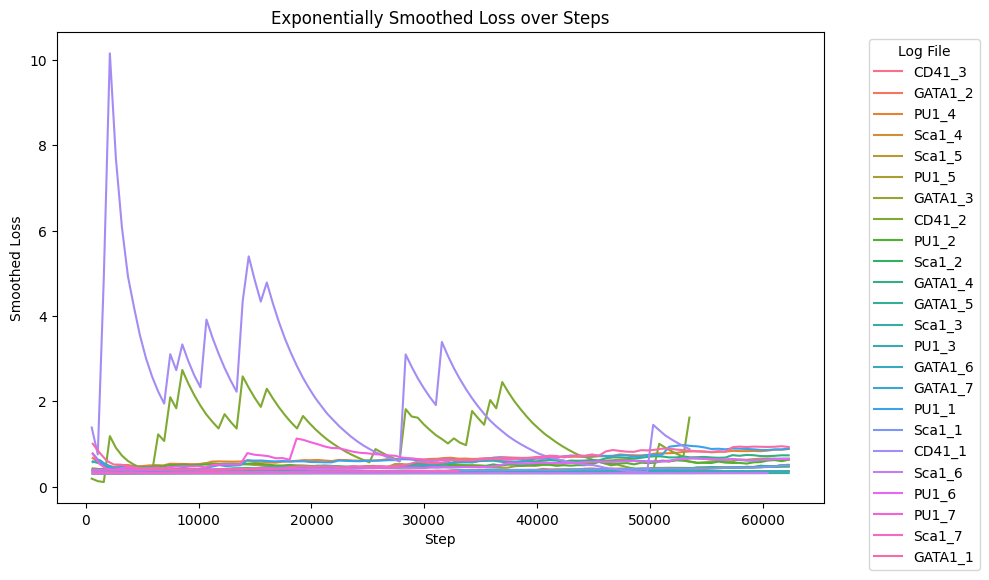

In [138]:
def exponential_moving_average(values, alpha=0.5):
    return values.ewm(alpha=alpha).mean()

# Apply exponential smoothing to your DataFrame
y = df_loss.groupby("file")["value"].transform(lambda x: exponential_moving_average(x, alpha=0.1))
df_loss['smoothed_value'] = y

# df_loss = df_loss[df_loss['file'] != 'version_12121098']

# Plot the smoothed data
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_loss, x='step', y="smoothed_value", hue="file")
plt.title("Exponentially Smoothed Loss over Steps")
plt.xlabel("Step")
plt.ylabel("Smoothed Loss")
plt.legend(title="Log File", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
